## Classification using NN

In [1]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import lib.utils as util
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

In [3]:
data = pd.read_csv('data/dataset.csv')
data

,Date,Time,S1Temp,S2Temp,S3Temp,S1Light,S2Light,S3Light,CO2,PIR1,PIR2,Persons
0,11/01/2021,10:53:33,19.90,19.67,19.49,242,68,106,390.0,0,0,1
1,11/01/2021,10:54:04,19.90,19.69,19.56,242,66,106,390.0,0,0,1
2,11/01/2021,10:54:34,19.99,19.66,19.44,242,68,106,390.0,0,0,1
3,11/01/2021,10:55:05,19.98,19.73,19.47,242,68,106,390.0,0,0,1
4,11/01/2021,10:55:36,19.95,19.72,19.51,242,68,108,390.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10124,16/01/2021,09:01:59,20.00,20.03,19.66,12,14,66,345.0,0,0,0
10125,16/01/2021,09:02:29,19.99,20.00,19.60,12,14,68,345.0,0,0,0
10126,16/01/2021,09:03:00,20.08,19.98,19.65,12,14,68,345.0,0,0,0
10127,16/01/2021,09:03:31,20.05,20.01,19.60,12,14,68,345.0,0,0,0


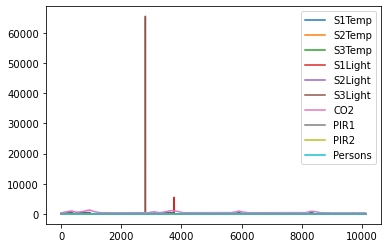

In [4]:
# remove missing values
data.dropna(inplace=True)
data.plot()
data.to_csv('data/dataset_no_missing.csv')

In [4]:
# prepare dates
data['Date'] = data['Date'].astype(str)+' '+data['Time'].astype(str)
data.drop(columns=['Time'], inplace=True)

In [5]:
data

,Date,S1Temp,S2Temp,S3Temp,S1Light,S2Light,S3Light,CO2,PIR1,PIR2,Persons
0,11/01/2021 10:53:33,19.90,19.67,19.49,242,68,106,390.0,0,0,1
1,11/01/2021 10:54:04,19.90,19.69,19.56,242,66,106,390.0,0,0,1
2,11/01/2021 10:54:34,19.99,19.66,19.44,242,68,106,390.0,0,0,1
3,11/01/2021 10:55:05,19.98,19.73,19.47,242,68,106,390.0,0,0,1
4,11/01/2021 10:55:36,19.95,19.72,19.51,242,68,108,390.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
10124,16/01/2021 09:01:59,20.00,20.03,19.66,12,14,66,345.0,0,0,0
10125,16/01/2021 09:02:29,19.99,20.00,19.60,12,14,68,345.0,0,0,0
10126,16/01/2021 09:03:00,20.08,19.98,19.65,12,14,68,345.0,0,0,0
10127,16/01/2021 09:03:31,20.05,20.01,19.60,12,14,68,345.0,0,0,0


In [6]:
df_without_outliers = util.detect_and_remove_outliers_std(data, k=6, ignore_cols=('Date', 'Persons'))
# removed 4 outliers (which dont make sense)

<AxesSubplot:>

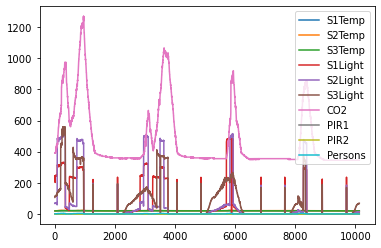

In [7]:
df_without_outliers.plot()

In [8]:
# in the end, test if averaging outliers is a better choice and has better results
# for k = 1 and k = 2 it removes too many relevant datapoints , so I chose k=4 (will test for k=2, k=3, k=3 in the end)
df_processed = df_without_outliers.copy()
df_processed.reset_index(inplace=True, drop=True)

# Decided to use new columns for using time information in the models
df_processed_with_dates = df_processed.copy()
format = "%d/%m/%Y %H:%M:%S"
df_processed_with_dates['Date'] = df_processed_with_dates['Date'].apply(lambda date: datetime.datetime.strptime(date, format))
df_processed_with_dates['Day'] = df_processed_with_dates['Date'].apply(lambda time: time.day)
df_processed_with_dates['Hour'] = df_processed_with_dates['Date'].apply(lambda time: time.hour)
df_processed_with_dates['Minute'] = df_processed_with_dates['Date'].apply(lambda time: time.minute)
df_processed_with_dates['Second'] = df_processed_with_dates['Date'].apply(lambda time: time.second)

df_processed.drop('Date', axis=1, inplace=True)
df_processed_with_dates.drop('Date', axis=1, inplace=True)

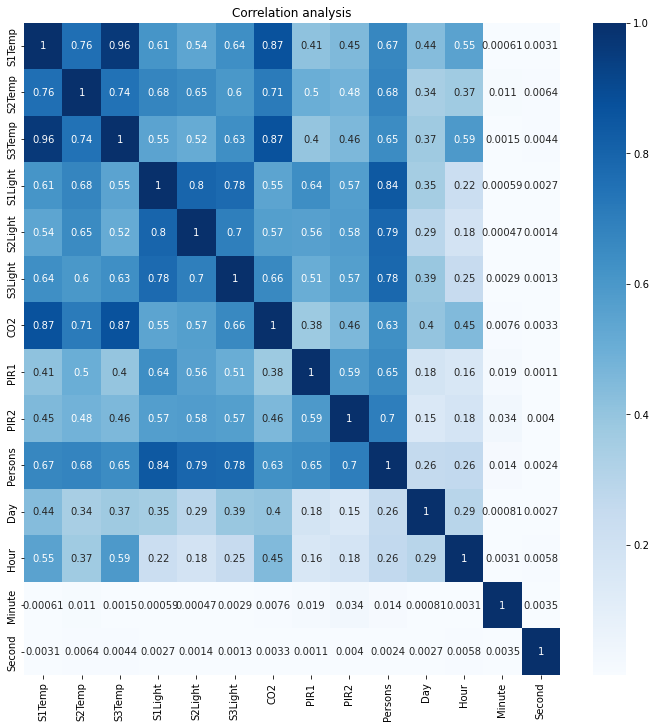

In [9]:
from matplotlib.pyplot import figure, savefig, show, title
from seaborn import heatmap

fig = figure(figsize=[12, 12])
corr_mtx = abs(df_processed_with_dates.corr())
heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
title('Correlation analysis')
show()

In [10]:
# FEATURE SELECTION
# Looking at the correlation matrix, we see that seconds and minutes is not
# relevant at all and days will damage our ability to predict future occurrences
# all other features have a good enough degree of correlation that we decided not to remove them

df_processed_with_dates.drop('Minute', axis=1, inplace=True)
df_processed_with_dates.drop('Second', axis=1, inplace=True)
df_processed_with_dates.drop('Day', axis=1, inplace=True)

# Classifier A

In [22]:
target_name = 'Persons'


def prepare_data_class_a(df):
    X = df.drop([target_name], axis=1)
    y = df[target_name]
    y = y.apply(lambda x: x > 2)
    return *util.split_dataset(X, y), X, y


def prepare_data_with_zscore(df):
    x_train, y_train, x_valid, y_valid, x_test, y_test, X, y = prepare_data_class_a(
        df.copy())
    x_train = stats.zscore(x_train)
    x_valid = stats.zscore(x_valid)
    x_test = stats.zscore(x_test)
    return x_train, y_train, x_valid, y_valid, x_test, y_test, X, y

In [23]:
from scipy import stats

# test split (without_dates)
x_train, y_train, x_valid, y_valid, x_test, y_test, X, y = prepare_data_class_a(
    df_processed)

# test split with dates
x_d_train, y_d_train, x_d_valid, y_d_valid, x_d_test, y_d_test, X_w_dates, y_w_dates = prepare_data_class_a(
    df_processed_with_dates)

# zscore scaling
x_zs_train, y_zs_train, x_zs_valid, y_zs_valid, x_zs_test, y_zs_test, X_zscore, y_zscore = prepare_data_with_zscore(
    df_processed)

# zscore scaling with dates
x_d_zs_train, y_d_zs_train, x_d_zs_valid, y_d_zs_valid, x_d_zs_test, y_d_zs_test, X_d_zscore, y_d_zscore = prepare_data_with_zscore(
    df_processed_with_dates)

# Will not apply min max because we dont know the range of the data to predict and the results were lower than zscore

# balanced df
x_bal_train_dfs = util.apply_balancing(x_d_train, y_d_train, target_name)
x_zs_bal_train_dfs = util.apply_balancing(x_zs_train, y_zs_train, target_name)

data_prep_approaches = {
    'Default without hour': (x_train, y_train, x_valid, y_valid, x_test,
                             y_test),
    'Default with hour': (x_d_train, y_d_train, x_d_valid, y_d_valid, x_d_test,
                          y_d_test),
    'Zscore without hour': (x_zs_train, y_zs_train, x_zs_valid, y_zs_valid,
                            x_zs_test, y_zs_test),
    'Zscore with hour': (x_d_zs_train, y_d_zs_train, x_d_zs_valid,
                         y_d_zs_valid, x_d_zs_test, y_d_zs_test),
    'Zscore - Over balanced':
    (x_zs_bal_train_dfs['over'][0], x_zs_bal_train_dfs['over'][1], x_zs_valid,
     y_zs_valid, x_zs_test, y_zs_test),
    'Zscore - SMOTE balanced':
    (x_zs_bal_train_dfs['smote'][0], x_zs_bal_train_dfs['smote'][1],
     x_zs_valid, y_zs_valid, x_zs_test, y_zs_test),
    'Default with hour - Over balanced':
    (x_bal_train_dfs['over'][0], x_bal_train_dfs['over'][1], x_d_valid,
     y_d_valid, x_d_test, y_d_test),
    'Default with hour - SMOTE balanced':
    (x_bal_train_dfs['smote'][0], x_bal_train_dfs['smote'][1], x_d_valid,
     y_d_valid, x_d_test, y_d_test),
}

False    6528
True      556
Name: Persons, dtype: int64
False    6528
True      556
Name: Persons, dtype: int64


### Baseline

In [24]:
baseline_models = {}
best_mlp_model = None
for key, value in data_prep_approaches.items():
    print(f"======== {key} =========")
    x_train, y_train, x_valid, y_valid, x_test, y_test = value
    neigh, mlp = util.run_class_baseline(x_train, y_train, x_valid, y_valid)
    scores_mlp = mlp[1]
    print(scores_mlp)
    avg_mlp_score = np.mean(scores_mlp)
    print(avg_mlp_score)
    baseline_models[key] = (neigh, mlp)
    if (best_mlp_model is None or avg_mlp_score > best_mlp_model[1]):
        best_mlp_model = (mlp[0], avg_mlp_score, key)
    print("===================================")

print(
    f"Best model ({best_mlp_model[1]}): {best_mlp_model[2]}-{best_mlp_model[0]}"
)


======== Default without hour =========
(0.9426877470355731, 0.8947368421052632, 0.576271186440678, 0.7010309278350517)
0.7786816758541415
======== Default with hour =========
(0.9565217391304348, 0.6447368421052632, 0.7424242424242424, 0.6901408450704226)
0.7584559171825908
======== Zscore without hour =========
(0.991600790513834, 0.9276315789473685, 0.9591836734693877, 0.94314381270903)
0.955389963909905
======== Zscore with hour =========
(0.9920948616600791, 0.9407894736842105, 0.9533333333333334, 0.9470198675496689)
0.958309384056823
======== Zscore - Over balanced =========
(0.9891304347826086, 0.9736842105263158, 0.891566265060241, 0.930817610062893)
0.9462996301080145
======== Zscore - SMOTE balanced =========
(0.991600790513834, 0.9736842105263158, 0.9192546583850931, 0.9456869009584664)
0.9575566400959273
======== Default with hour - Over balanced =========
(0.9594861660079052, 0.8157894736842105, 0.6966292134831461, 0.7515151515151515)
0.8058550011726033
======== Default wi

### Hyperparameter tuning with Cross Validation

After having a baseline model, we're going to tune the parametersto see if we get any improvement.

We also had in mind that our baseline showed a better result using zscore with the feature of hours.

We'll mix and match them to get the most out of the models and test it with cross validation. 

This is the setup that we'll be working with:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" alt="drawing" width="600"/>

In [28]:
# generate hyper parameters
# preliminary testing showed that the sweet spot for layer sizes is with 2 hidden layers, and more than 2 neurons
# we need further testing for finding the best parameter
layer_sizes = []
for i in np.arange(2, 50, 6):
    for f in np.arange(2, 50, 6):
        layer_sizes.append((i, f))

print(layer_sizes)
hyper_parameters = {
    "hidden_layer_sizes": layer_sizes,
    'activation': ['tanh', "relu", "logistic"], 
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['adaptive'],
}

parameters = []
for a in hyper_parameters['hidden_layer_sizes'] :
    for b in hyper_parameters['activation'] :
        for c in hyper_parameters['solver'] :
            for d in hyper_parameters['alpha'] :
                for e in hyper_parameters['learning_rate'] :
                    parameters.append( ( a, b, c, d, e) )

print(len(parameters))
import psutil

thread_count = psutil.cpu_count()
print(thread_count)

[(2, 2), (2, 8), (2, 14), (2, 20), (2, 26), (2, 32), (2, 38), (2, 44), (8, 2), (8, 8), (8, 14), (8, 20), (8, 26), (8, 32), (8, 38), (8, 44), (14, 2), (14, 8), (14, 14), (14, 20), (14, 26), (14, 32), (14, 38), (14, 44), (20, 2), (20, 8), (20, 14), (20, 20), (20, 26), (20, 32), (20, 38), (20, 44), (26, 2), (26, 8), (26, 14), (26, 20), (26, 26), (26, 32), (26, 38), (26, 44), (32, 2), (32, 8), (32, 14), (32, 20), (32, 26), (32, 32), (32, 38), (32, 44), (38, 2), (38, 8), (38, 14), (38, 20), (38, 26), (38, 32), (38, 38), (38, 44), (44, 2), (44, 8), (44, 14), (44, 20), (44, 26), (44, 32), (44, 38), (44, 44)]
1152
16


In [29]:
from sklearn.neural_network import MLPClassifier
import psutil
from tqdm.auto import tqdm

x_train = x_d_zs_train
y_train = y_d_zs_train
x_valid = x_d_zs_valid
y_valid = y_d_zs_valid
x_test = x_d_zs_test
y_test = y_d_zs_test

# we'll now join both train and validation so that we can perform cross validation
X = pd.concat([x_train, x_valid], ignore_index=True)
y = pd.concat([y_train, y_valid], ignore_index=True)
cv = 5 # fold count
max_iter = 500

In [30]:
models = []  # [(model, acc)]
best_model = None

for i in tqdm (range (len(parameters)), desc="Running models..."):
    p = parameters[i]
    mlp = MLPClassifier(hidden_layer_sizes=p[0],
                        activation=p[1],
                        solver=p[2],
                        alpha=p[3],
                        learning_rate=p[4],
                        max_iter=max_iter)
    scores, avg_score = util.cross_validation(X, y, mlp, cv)
    models.append((mlp, avg_score, scores, p))

for m in models:
    if best_model is None or best_model[1] < m[1]:
        best_model = m
print(best_model)
best_model[0].fit(x_train, y_train)
filename = f"models/classifier_A"
util.save_model(filename, best_model[0])

Running models...:   0%|          | 0/1152 [00:00<?, ?it/s]

(MLPClassifier(alpha=0.001, hidden_layer_sizes=(44, 26),
              learning_rate='adaptive', max_iter=500, solver='lbfgs'), 0.9798763968892107, {'fit_time': array([13.68947768, 13.01787329, 14.93661451, 15.35199261, 15.01969028]), 'score_time': array([0.00900888, 0.01000285, 0.00800967, 0.00800729, 0.00900817]), 'test_accuracy': array([0.99396268, 0.99506037, 0.99560922, 0.99725426, 0.99670511]), 'test_balanced_accuracy': array([0.97738514, 0.9844274 , 0.98794852, 0.99201494, 0.98846884]), 'test_recall': array([0.95774648, 0.97183099, 0.97887324, 0.9858156 , 0.9787234 ]), 'test_precision': array([0.96453901, 0.96503497, 0.96527778, 0.97887324, 0.9787234 ]), 'test_f1': array([0.96113074, 0.96842105, 0.97202797, 0.98233216, 0.9787234 ])}, ((44, 26), 'relu', 'lbfgs', 0.001, 'adaptive'))


### Evaluation

MLP accuracy : 0.991600790513834
MLP recall : 0.9868421052631579
MLP precision : 0.9090909090909091
MLP f1 score : 0.9463722397476341


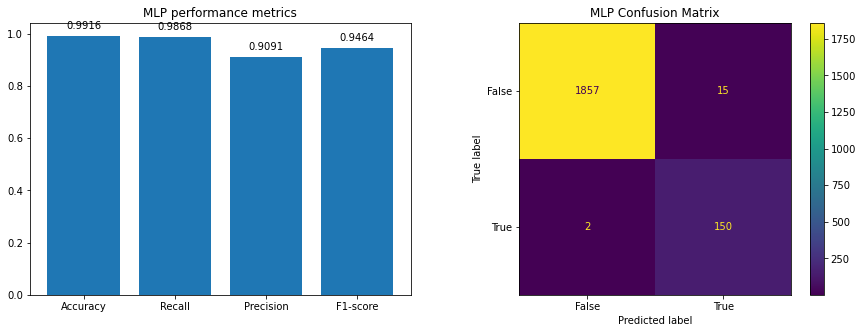

In [25]:
# Showing results for the validation dataset
filename = f"models/classifier_A"
loaded_model = util.load_model(filename)
y_pred = loaded_model.predict(x_valid)
results = util.get_model_results(y_valid, y_pred)
print("Results for Validation Set")
util.print_results('MLP',
                   results,
                   y_valid,
                   y_pred,
                   x_valid,
                   loaded_model,
                   with_chart=True)

MLP accuracy : 0.998025666337611
MLP recall : 0.9863013698630136
MLP precision : 0.9863013698630136
MLP f1 score : 0.9863013698630136


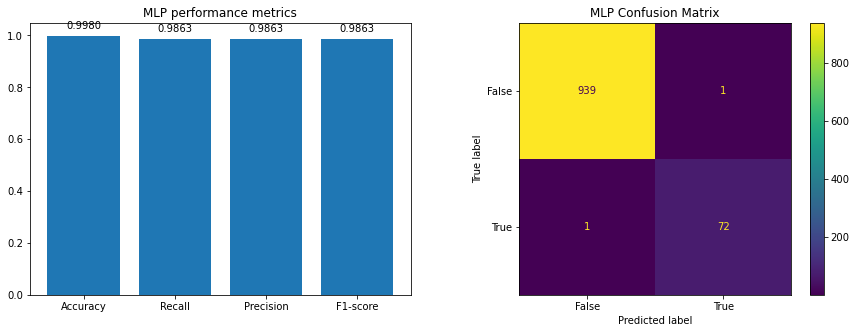

In [26]:
# Showing results for the test dataset
loaded_model = util.load_model(filename)
y_pred = loaded_model.predict(x_test)
results = util.get_model_results(y_test, y_pred)
print("Results for Test Set")
util.print_results('MLP',
                   results,
                   y_test,
                   y_pred,
                   x_test,
                   loaded_model,
                   with_chart=True)

# Classifier B

### Preparation

In [12]:
target_name = 'Persons'

def prepare_data_class_b(df):
    X = df.drop([target_name], axis=1)
    y = df[target_name]
    return *util.split_dataset(X, y), X, y


def prepare_data_b_with_zscore(df):
    x_train, y_train, x_valid, y_valid, x_test, y_test, X, y = prepare_data_class_b(
        df.copy())
    x_train = stats.zscore(x_train)
    x_valid = stats.zscore(x_valid)
    x_test = stats.zscore(x_test)
    return x_train, y_train, x_valid, y_valid, x_test, y_test, X, y

In [13]:
from scipy import stats

# test split (without_dates)
x_train, y_train, x_valid, y_valid, x_test, y_test, X, y = prepare_data_class_b(
    df_processed)

# test split with dates
x_d_train, y_d_train, x_d_valid, y_d_valid, x_d_test, y_d_test, X_w_dates, y_w_dates = prepare_data_class_b(
    df_processed_with_dates)

# zscore scaling
x_zs_train, y_zs_train, x_zs_valid, y_zs_valid, x_zs_test, y_zs_test, X_zscore, y_zscore = prepare_data_b_with_zscore(
    df_processed)

# zscore scaling with dates
x_d_zs_train, y_d_zs_train, x_d_zs_valid, y_d_zs_valid, x_d_zs_test, y_d_zs_test, X_d_zscore, y_d_zscore = prepare_data_b_with_zscore(
    df_processed_with_dates)

data_prep_approaches_B = {
    'Default without hour':
    (x_train, y_train, x_valid, y_valid, x_test, y_test),
    'Default with hour':
    (x_d_train, y_d_train, x_d_valid, y_d_valid, x_d_test, y_d_test),
    'Zscore without hour':
    (x_zs_train, y_zs_train, x_zs_valid, y_zs_valid, x_zs_test, y_zs_test),
    'Zscore with hour': (x_d_zs_train, y_d_zs_train, x_d_zs_valid,
                         y_d_zs_valid, x_d_zs_test, y_d_zs_test),
}

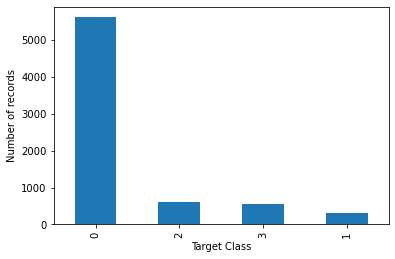

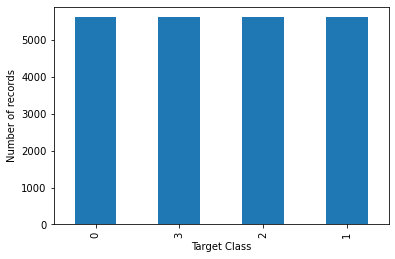

In [14]:
# Studying Data balancing

import matplotlib.pyplot as plt

x_train = x_d_zs_train.copy()
y_train = y_d_zs_train.copy()
x_valid = x_d_zs_valid.copy()
y_valid = y_d_zs_valid.copy()
x_test = x_d_zs_test.copy()
y_test = y_d_zs_test.copy()

count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

# Class 0 is much more apparent

from imblearn.over_sampling import SMOTE

over_sampler = SMOTE()
x_bal, y_bal = over_sampler.fit_resample(x_train, y_train)


count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

# We balanced the data for each minority class (SMOTE function default)

In [15]:
# Applying multiclass balancing

x_d_train_bal, y_d_train_bal = util.balancing_multiclass(x_d_train, y_d_train)
x_zs_train_bal, y_zs_train_bal = util.balancing_multiclass(x_zs_train, y_zs_train)
x_d_zs_train_bal, y_d_zs_train_bal = util.balancing_multiclass(x_d_zs_train, y_d_zs_train)

data_prep_approaches_B['Zscore - SMOTE sampled'] = (x_zs_train_bal,
                                                    y_zs_train_bal, x_zs_valid,
                                                    y_zs_valid, x_zs_test,
                                                    y_zs_test)
data_prep_approaches_B['Zscore with hour - SMOTE sampled'] = (x_d_zs_train_bal, y_d_zs_train_bal, x_d_zs_valid, y_d_zs_valid, x_d_zs_test, y_d_zs_test)
data_prep_approaches_B['Default with hour - SMOTE sampled'] = (x_d_train_bal, y_d_train_bal, x_d_valid,y_d_valid, x_d_test, y_d_test)

In [15]:
baseline_models_B = {}
best_mlp_model_B = None
for key, value in data_prep_approaches_B.items():
    print(f"======== {key} =========")
    x_train, y_train, x_valid, y_valid, x_test, y_test = value
    neigh, mlp = util.run_class_baseline(x_train, y_train, x_valid, y_valid, ignore_results=True)
    X = pd.concat([x_train, x_valid], ignore_index=True)
    y = pd.concat([y_train, y_valid], ignore_index=True)
    knn_score, knn_all_avg_score = util.cross_validation(X, y, neigh, fold_count=5, multiclass=True)
    mlp_score, mlp_all_avg_score = util.cross_validation(X, y, mlp, fold_count=5, multiclass=True)
    print(f'KNN: {knn_all_avg_score}')
    print(f'MLP: {mlp_all_avg_score}')
    neigh.fit(x_train, y_train)
    mlp.fit(x_train, y_train)
    baseline_models_B[key] = (neigh, mlp)
    if (best_mlp_model_B is None or mlp_all_avg_score > best_mlp_model_B[1]):
        best_mlp_model_B = (mlp, mlp_all_avg_score, key)
    print("===================================")

print(
    f"Best model ({best_mlp_model_B[1]}): {best_mlp_model_B[2]}-{best_mlp_model_B[0]}"
)

# Apparently smote sampling did not help the avg score of the model and the best is zscore with dates
# but zscore SMOTE balanced is a more reliable dataset, because we're dealing with
# classes that contain the same occurrences as the others

======== Default without hour =========
KNN: 0.9861059261875557
MLP: 0.4698283816941
======== Default with hour =========
KNN: 0.9861059261875557
MLP: 0.4698283816941
======== Zscore without hour =========
KNN: 0.9819599058031765
MLP: 0.9780352018405342
======== Zscore with hour =========
KNN: 0.9821122450351863
MLP: 0.9801278924103124
======== Zscore - SMOTE sampled =========
KNN: 0.9975933213184398
MLP: 0.9754857209124722
======== Zscore with hour - SMOTE sampled =========
KNN: 0.9968313140131032
MLP: 0.9789144225340835
======== Default with hour - SMOTE sampled =========
KNN: 0.9965803034261855
MLP: 0.2242523071914156
Best model (0.9801278924103124): Zscore with hour-MLPClassifier(hidden_layer_sizes=5, random_state=42, solver='lbfgs')


### Hyperparameter tuning with Cross Validation

Now we'll perform the same hyperparameter tuning that we applied to the classifier A.

In [17]:
# generate hyper parameters
layer_sizes = []
for i in np.arange(3, 15, 2): # from (3,3) to (15, 15) because more neurons becomes very heavy and unnecessary
    for f in np.arange(3, 15, 2):
        layer_sizes.append((i, f))

print(layer_sizes)

# from previous testing we know that tanh activation and adam/sgd solvers are not great for this dataset, so we will not include
# them in our hyperparameter tuning
hyper_parameters = {
    "hidden_layer_sizes": layer_sizes,
    'activation': ["relu", "logistic"],
    'solver': ['lbfgs'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['adaptive'],
}

parameters = []
for a in hyper_parameters['hidden_layer_sizes']:
    for b in hyper_parameters['activation']:
        for c in hyper_parameters['solver']:
            for d in hyper_parameters['alpha']:
                for e in hyper_parameters['learning_rate']:
                    parameters.append((a, b, c, d, e))

print(len(parameters))
import psutil

thread_count = psutil.cpu_count()
print(thread_count)

[(3, 3), (3, 5), (3, 7), (3, 9), (3, 11), (3, 13), (5, 3), (5, 5), (5, 7), (5, 9), (5, 11), (5, 13), (7, 3), (7, 5), (7, 7), (7, 9), (7, 11), (7, 13), (9, 3), (9, 5), (9, 7), (9, 9), (9, 11), (9, 13), (11, 3), (11, 5), (11, 7), (11, 9), (11, 11), (11, 13), (13, 3), (13, 5), (13, 7), (13, 9), (13, 11), (13, 13)]
144
16


In [18]:
from sklearn.neural_network import MLPClassifier
import psutil
from tqdm.auto import tqdm

x_train = x_d_zs_train_bal
y_train = y_d_zs_train_bal
x_valid = x_d_zs_valid
y_valid = y_d_zs_valid
x_test = x_d_zs_test
y_test = y_d_zs_test

# we'll now join both train and validation so that we can perform cross validation
X = pd.concat([x_train, x_valid], ignore_index=True)
y = pd.concat([y_train, y_valid], ignore_index=True)
cv = 5  # fold count
max_iter = 1000

In [19]:
models = []  # [(model, acc)]
best_model = None
# create queue for threads to get from

for i in tqdm (range (len(parameters)), desc="Running models..."):
    p = parameters[i]
    mlp = MLPClassifier(hidden_layer_sizes=p[0],
                        activation=p[1],
                        solver=p[2],
                        alpha=p[3],
                        learning_rate=p[4],
                        max_iter=max_iter)
    scores, avg_score = util.cross_validation(X, y, mlp, cv, multiclass=True)
    models.append((mlp, avg_score, scores, p))
    #print(f"Model Average Score: {avg_score:.5f}\nParameters: {p}\n\n")

for m in models:
    if best_model is None or best_model[1] < m[1]:
        best_model = m
print(best_model)
best_model[0].fit(x_train, y_train)
filename = f"models/classifier_B"
util.save_model(filename, best_model[0])

Running models...:   0%|          | 0/144 [00:00<?, ?it/s]

(MLPClassifier(alpha=0.001, hidden_layer_sizes=(13, 13),
              learning_rate='adaptive', max_iter=1000, solver='lbfgs'), 0.9936075289920844, {'fit_time': array([30.04638267, 30.13645887, 30.51981807, 30.04037547, 29.14155197]), 'score_time': array([0.01801205, 0.01401472, 0.0140121 , 0.0150106 , 0.01801705]), 'test_balanced_accuracy': array([0.99185181, 0.99243295, 0.99122677, 0.99722862, 0.99468248]), 'test_recall_micro': array([0.9922338 , 0.99284692, 0.99162068, 0.99734314, 0.99488962]), 'test_recall_macro': array([0.99185181, 0.99243295, 0.99122677, 0.99722862, 0.99468248]), 'test_precision_micro': array([0.9922338 , 0.99284692, 0.99162068, 0.99734314, 0.99488962]), 'test_precision_macro': array([0.99181844, 0.99243023, 0.99119611, 0.99719302, 0.99464627]), 'test_f1_micro': array([0.9922338 , 0.99284692, 0.99162068, 0.99734314, 0.99488962]), 'test_f1_macro': array([0.99183145, 0.99243076, 0.99119924, 0.99721056, 0.99465967])}, ((13, 13), 'relu', 'lbfgs', 0.001, 'adaptive'))

### Evaluation

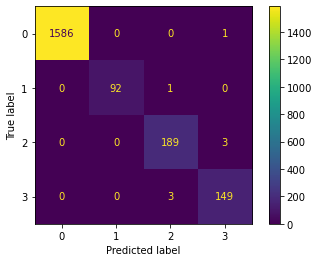

Micro Precision: 0.9960474308300395
Macro Precision: 0.9883138374999866
Micro Recall: 0.9960474308300395
Macro Recall: 0.9882827051373226
Micro Accuracy: 0.9960474308300395
Macro Accuracy: 0.9980237154150198
Micro F-measure: 0.9960474308300395
Macro F-measure: 0.988286699396318
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997      1587
           1     1.0000    0.9892    0.9946        93
           2     0.9793    0.9844    0.9818       192
           3     0.9739    0.9803    0.9770       152

    accuracy                         0.9960      2024
   macro avg     0.9883    0.9883    0.9883      2024
weighted avg     0.9961    0.9960    0.9961      2024



In [16]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Showing results for the validation dataset
filename = f"models/classifier_B"
loaded_model = util.load_model(filename)
y_pred = loaded_model.predict(x_valid)
multilabel_confusion_matrix(y_valid, y_pred)
plot_confusion_matrix(loaded_model, x_valid, y_valid)
plt.show()
_ = util.get_multiclass_results(y_valid, y_pred)
print(classification_report(y_valid, y_pred, digits=4))

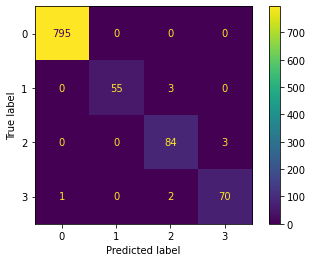

Micro Precision: 0.9911154985192497
Macro Precision: 0.9681743032593292
Micro Recall: 0.9911154985192497
Macro Recall: 0.9753670132252767
Micro Accuracy: 0.9911154985192497
Macro Accuracy: 0.9955577492596248
Micro F-measure: 0.9911154985192497
Macro F-measure: 0.9715680890139669
              precision    recall  f1-score   support

           0     0.9987    1.0000    0.9994       795
           1     1.0000    0.9483    0.9735        58
           2     0.9438    0.9655    0.9545        87
           3     0.9589    0.9589    0.9589        73

    accuracy                         0.9911      1013
   macro avg     0.9754    0.9682    0.9716      1013
weighted avg     0.9912    0.9911    0.9911      1013



In [17]:
# Showing results for the TEST dataset
y_pred = loaded_model.predict(x_test)
multilabel_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(loaded_model, x_test, y_test)
plt.show()
_ = util.get_multiclass_results(y_test, y_pred)
print(classification_report(y_test, y_pred, digits=4))